In [1]:
### Install required modules
!pip install "stable_baselines3[extra]>=2.0.0a9"
#!pip install gymnasium[atari]
#!pip install gymnasium[accept-rom-license]
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 45.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=069e556b8e74b3df04562bfd084f6cd9cbc044aeccd823fd4cce52961badd47e
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/data

Mounted at /content/drive
/content/drive/MyDrive/data


In [3]:
### Import modules
import gymnasium
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


In [4]:
### Create environment
env = make_atari_env("ALE/SpaceInvaders-v5")

In [ ]:
### Train model

# Where to store training log
log_dir = 'atari_train_log'

# Instantiate model
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log = log_dir)

# Train
model.learn(total_timesteps= 100000, progress_bar = True)
model.save("ppo_model1")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100,344/100,000  [ 0:11:46 < 0:00:00 , 147 it/s ]

In [ ]:
### Load the TensorBoard event files

event_file = log_dir + '/PPO_3'
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# Get the list of available tags (summary keys)
#tags = event_acc.Tags()

# Retrieve the training episode rewards from the event files
episode_rewards = event_acc.Scalars('rollout/ep_rew_mean') # mean episode rewards
step = [episode.step for episode in episode_rewards]
reward = [episode.value for episode in episode_rewards]

Text(0, 0.5, 'Mean Episode Reward')

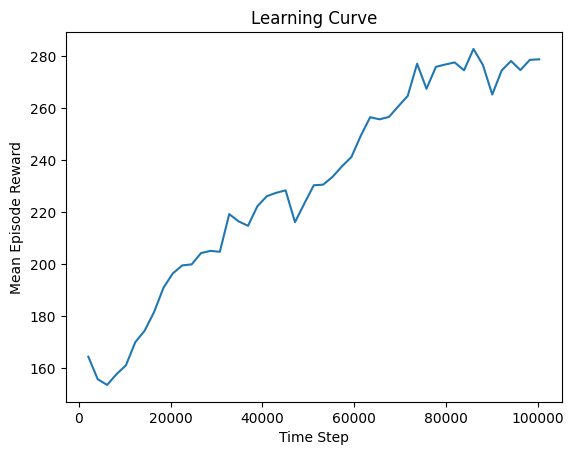

In [ ]:
### Plot the learning curve
plt.plot(step, reward)
plt.title('Learning Curve')
plt.xlabel('Time Step')
plt.ylabel('Mean Episode Reward')

In [ ]:
#model = model.load("/content/drive/MyDrive/data/ppo_model1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
### Functions to record video
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(vec_env, model,fps, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    # eval_env = DummyVecEnv([lambda: gym.make("CartPole-v1", render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    vec_env.metadata["render_fps"] = fps
    vec_env = VecVideoRecorder(
        vec_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix
    )

    obs = vec_env.reset()
    for _ in range(video_length):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = vec_env.step(action)

    # Close the video recorder
    vec_env.close()

In [ ]:
record_video(env, model,fps = 20, video_length=1000, prefix="ppo-1")
show_videos("videos", prefix="ppo-1")

Saving video to /content/drive/MyDrive/data/videos/ppo-1-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/data/videos/ppo-1-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/data/videos/ppo-1-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/data/videos/ppo-1-step-0-to-step-1000.mp4


## **Now trying with DQN:**

In [6]:
import gym
from stable_baselines3 import DQN

In [7]:
### Training the first DQN model

# Where to store training log
log_dir = 'atari_train_log'

# Instantiate model
DQN_1 = DQN('MlpPolicy', env, verbose=1, tensorboard_log = log_dir)

# Train
DQN_1.learn(total_timesteps= 100000, progress_bar = True)
DQN_1.save("dqn_model1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 11.56GB
  warnings.warn(


Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_1


Output()

Streaming output truncated to the last 5000 lines.
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 984      |
|    fps              | 246      |
|    time_elapsed     | 157      |
|    total_timesteps  | 38815    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 513      |
|    ep_rew_mean      | 129      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 988      |
|    fps              | 246      |
|    time_elapsed     | 158      |
|    total_timesteps  | 39000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 520      |
|    ep_rew_mean      | 130      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 992      |
|    fps              | 246      |
|    time_elapsed     | 159      |
|   

In [8]:
### Load the TensorBoard event files

event_file = log_dir + '/DQN_1'
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# Get the list of available tags (summary keys)
#tags = event_acc.Tags()

# Retrieve the training episode rewards from the event files
episode_rewards = event_acc.Scalars('rollout/ep_rew_mean') # mean episode rewards
step = [episode.step for episode in episode_rewards]
reward = [episode.value for episode in episode_rewards]

Text(0, 0.5, 'Mean Episode Reward')

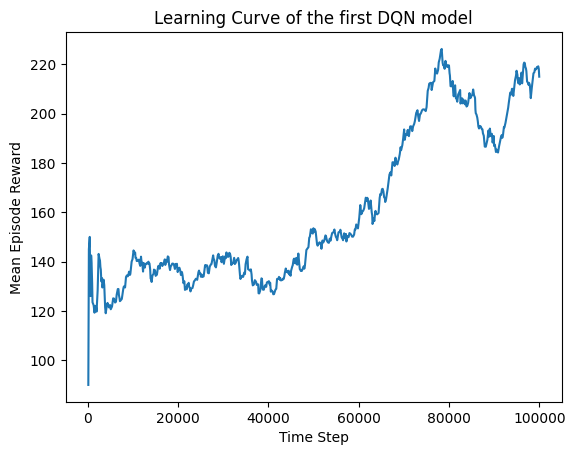

In [9]:
### Plot the learning curve
plt.plot(step, reward)
plt.title('Learning Curve of the first DQN model')
plt.xlabel('Time Step')
plt.ylabel('Mean Episode Reward')

In [11]:
record_video(env, DQN_1,fps = 20, video_length=1000, prefix="dqn-1")
show_videos("videos", prefix="dqn-1")

Saving video to /content/drive/MyDrive/data/videos/dqn-1-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/data/videos/dqn-1-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/data/videos/dqn-1-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/data/videos/dqn-1-step-0-to-step-1000.mp4


### Now we use a grid search to find the optinmal hyper parameters for this specific DQN with the policy of "MlpPolicy"

In [14]:
# Define the grid of hyperparameters to search over
learning_rates = [1e-2, 1e-3, 1e-4]
gammas = [0.9, 0.95, 0.99]
buffer_sizes = [10000, 50000, 100000]

best_mean_reward = -float('inf')  # Initialize the best mean reward to negative infinity
best_hyperparams = None

# Iterate over all combinations of hyperparameters
for learning_rate in learning_rates:
    for gamma in gammas:
        for buffer_size in buffer_sizes:
            # Create and train the DQN model
            DQN_model = DQN('MlpPolicy', env, verbose=1, tensorboard_log=log_dir,
                            gamma=gamma, learning_rate=learning_rate, buffer_size=buffer_size)
            DQN_model.learn(total_timesteps=20)

            # Evaluate the model on the environment
            mean_reward, _ = evaluate_policy(DQN_model,env, n_eval_episodes=5)

            # If this model's mean reward is the highest found so far, update the best mean reward and best hyperparameters
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                best_hyperparams = (learning_rate, gamma, buffer_size)

# Print the best hyperparameters
print('Best mean reward achieved:', best_mean_reward)
print('Best hyperparameters:', best_hyperparams)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_17
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_18
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_19
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_20
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_21
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_22
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_23
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_24
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_25
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_26
Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to 

Here It took super long with 100000 iterations hence it was reduced to 20. Here we can see the best hyper parameters are with a learning rate of 0.01, a gamma of 0.95 and a buffer size of 50000. Now we can implement this fully and see the curve:

In [15]:
learning_rate = 1e-2
gamma = 0.95
buffer_sizes = 50000
# Instantiate model
DQN_mlp = DQN('MlpPolicy', env, verbose=1, tensorboard_log = log_dir,gamma=gamma, learning_rate=learning_rate, buffer_size=buffer_size)

# Train
DQN_mlp.learn(total_timesteps= 100000, progress_bar = True)
DQN_mlp.save("dqn_mmlp")


In [18]:
DQN_mlp.save("dqn_mmlp")

In [19]:
### Load the TensorBoard event files

event_file = log_dir + '/DQN_44'
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# Get the list of available tags (summary keys)
#tags = event_acc.Tags()

# Retrieve the training episode rewards from the event files
episode_rewards = event_acc.Scalars('rollout/ep_rew_mean') # mean episode rewards
step = [episode.step for episode in episode_rewards]
reward = [episode.value for episode in episode_rewards]

Text(0, 0.5, 'Mean Episode Reward')

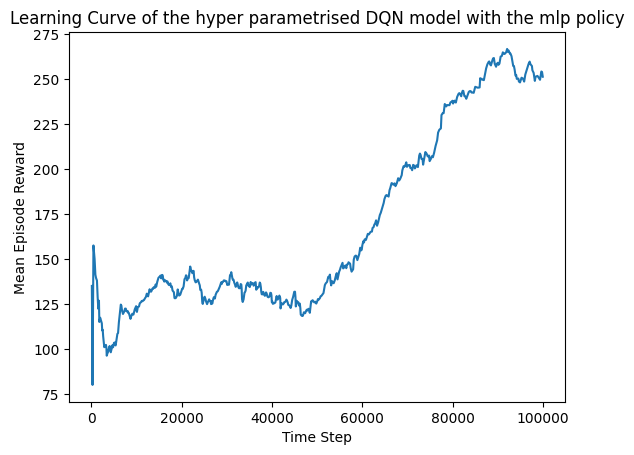

In [20]:
### Plot the learning curve
plt.plot(step, reward)
plt.title('Learning Curve of the hyper parametrised DQN model with the mlp policy')
plt.xlabel('Time Step')
plt.ylabel('Mean Episode Reward')

In [21]:
record_video(env, DQN_mlp,fps = 20, video_length=1000, prefix="dqn-mlp")
show_videos("videos", prefix="dqn-mlp")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving video to /content/drive/MyDrive/data/videos/dqn-mlp-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/data/videos/dqn-mlp-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/data/videos/dqn-mlp-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/data/videos/dqn-mlp-step-0-to-step-1000.mp4


## Now the DQN with a different policy- a Cnn policy:

In [22]:
# Instantiate model
DQN_policy2 = DQN('CnnPolicy', env, verbose=1, tensorboard_log = log_dir)
# Train
DQN_policy2.learn(total_timesteps= 100000, progress_bar = True)
DQN_policy2.save("dqn_policy2")

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to atari_train_log/DQN_45


Output()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 4.62GB
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    fps              | 240      |
|    time_elapsed     | 161      |
|    total_timesteps  | 38818    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 528      |
|    ep_rew_mean      | 140      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 976      |
|    fps              | 240      |
|    time_elapsed     | 161      |
|    total_timesteps  | 38901    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 526      |
|    ep_rew_mean      | 139      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 980      |
|    fps              | 240      |
|    time_elapsed     | 162      |
|    total_timesteps  | 39011    |
----------------------------------
----------------------------------
| ro

Text(0, 0.5, 'Mean Episode Reward')

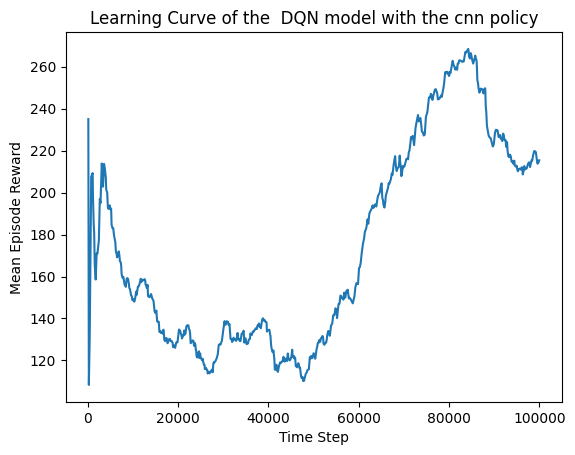

In [25]:
event_file = log_dir + '/DQN_45'
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# Get the list of available tags (summary keys)
#tags = event_acc.Tags()

# Retrieve the training episode rewards from the event files
episode_rewards = event_acc.Scalars('rollout/ep_rew_mean') # mean episode rewards
step = [episode.step for episode in episode_rewards]
reward = [episode.value for episode in episode_rewards]
### Plot the learning curve
plt.plot(step, reward)
plt.title('Learning Curve of the  DQN model with the cnn policy')
plt.xlabel('Time Step')
plt.ylabel('Mean Episode Reward')

In [26]:
record_video(env, DQN_policy2,fps = 20, video_length=1000, prefix="dqn-policy2")
show_videos("videos", prefix="dqn-policy2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving video to /content/drive/MyDrive/data/videos/dqn-policy2-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/data/videos/dqn-policy2-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/data/videos/dqn-policy2-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/data/videos/dqn-policy2-step-0-to-step-1000.mp4
